## cifar training workflow (lite version)

This is a small training workflow with minimum amount of functions required, for debugging purposes: I need to reach the standard 90+ accuracy on the test set

In [1]:
# IMPORTS

import os
import sys

ENV = 'colab'

if ENV == 'colab':
  # for running on google drive:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount=True)

  !pip install fvcore -q
  !pip install -e "/content/drive/My Drive/Bayes-Stochastic-Depth" -q

  module_dir = "/content/drive/My Drive/Bayes-Stochastic-Depth/src"
  # append local module to path
  module_path = os.path.abspath(os.path.join(module_dir))
  if module_path not in sys.path:
      sys.path.append(module_path)

  data_dir = "/content/drive/My Drive/Bayes-Stochastic-Depth/data"

elif ENV == 'local':
  data_dir = "../data"

from typing import Any, Callable, List, Optional, Type, Union, Tuple, Dict
from torch import Tensor

import os
import sys
import torch
from torch import nn, optim, mps
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from models import resnet
from data import get_dataset
from visualization import show_cifar_images
from training import (
    AccuracyMetric,
    get_confusion_matrix,
    parse_loss,
    parse_scheduler,
    parse_optimizer,
    get_dataset_classes,
)
from utils import (
    bayes_eval,
    bayes_forward,
    count_FLOPS,
    count_parameters,
    calculate_storage_in_mb,
)

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

print(f'Using Device {device}')

Using Device cuda:0


In [4]:
classes = get_dataset_classes("cifar10")

transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform_test
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define the resnet and attach predictor
net = torchvision.models.resnet18()
net.fc = nn.Linear(in_features=512, out_features=10)

net.to(device)
print('')

In [7]:
# Define the optimizer, loss func, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [12]:
def train(epoch):
    print("\nEpoch: %d" % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, targets in tqdm(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(
        "Acc: %.3f%% (%d/%d)" % (100.0 * correct / total, correct, total),
    )

In [13]:
# evaluate model
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(
            "Acc: %.3f%% (%d/%d)" % (100.0 * correct / total, correct, total),
        )
    # Save checkpoint.
    acc = 100.0 * correct / total

    return acc

In [14]:
history = []
start_epoch = 0
for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test_acc = test(epoch)
    history.append(test_acc)
    scheduler.step()


Epoch: 0


100%|██████████| 391/391 [00:25<00:00, 15.11it/s]


Acc: 49.192% (24596/50000)


100%|██████████| 100/100 [00:02<00:00, 35.70it/s]


Acc: 58.130% (5813/10000)

Epoch: 1


100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


Acc: 56.710% (28355/50000)


100%|██████████| 100/100 [00:02<00:00, 34.86it/s]


Acc: 61.760% (6176/10000)

Epoch: 2


100%|██████████| 391/391 [00:24<00:00, 16.10it/s]


Acc: 61.436% (30718/50000)


100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


Acc: 63.490% (6349/10000)

Epoch: 3


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]


Acc: 64.412% (32206/50000)


100%|██████████| 100/100 [00:02<00:00, 34.76it/s]


Acc: 67.340% (6734/10000)

Epoch: 4


100%|██████████| 391/391 [00:27<00:00, 14.40it/s]


Acc: 67.076% (33538/50000)


100%|██████████| 100/100 [00:02<00:00, 35.00it/s]


Acc: 66.050% (6605/10000)

Epoch: 5


100%|██████████| 391/391 [00:24<00:00, 15.83it/s]


Acc: 68.390% (34195/50000)


100%|██████████| 100/100 [00:04<00:00, 22.32it/s]


Acc: 66.490% (6649/10000)

Epoch: 6


100%|██████████| 391/391 [00:25<00:00, 15.59it/s]


Acc: 69.556% (34778/50000)


100%|██████████| 100/100 [00:02<00:00, 36.02it/s]


Acc: 69.110% (6911/10000)

Epoch: 7


100%|██████████| 391/391 [00:27<00:00, 14.36it/s]


Acc: 70.774% (35387/50000)


100%|██████████| 100/100 [00:02<00:00, 35.55it/s]


Acc: 70.470% (7047/10000)

Epoch: 8


100%|██████████| 391/391 [00:25<00:00, 15.41it/s]


Acc: 71.582% (35791/50000)


100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


Acc: 69.110% (6911/10000)

Epoch: 9


100%|██████████| 391/391 [00:25<00:00, 15.49it/s]


Acc: 72.360% (36180/50000)


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


Acc: 69.110% (6911/10000)

Epoch: 10


100%|██████████| 391/391 [00:27<00:00, 14.13it/s]


Acc: 72.956% (36478/50000)


100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


Acc: 71.070% (7107/10000)

Epoch: 11


100%|██████████| 391/391 [00:25<00:00, 15.08it/s]


Acc: 72.988% (36494/50000)


100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


Acc: 71.170% (7117/10000)

Epoch: 12


100%|██████████| 391/391 [00:24<00:00, 15.84it/s]


Acc: 73.890% (36945/50000)


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


Acc: 70.420% (7042/10000)

Epoch: 13


100%|██████████| 391/391 [00:27<00:00, 14.22it/s]


Acc: 74.354% (37177/50000)


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


Acc: 73.560% (7356/10000)

Epoch: 14


100%|██████████| 391/391 [00:26<00:00, 14.56it/s]


Acc: 74.040% (37020/50000)


100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Acc: 72.980% (7298/10000)

Epoch: 15


100%|██████████| 391/391 [00:24<00:00, 15.71it/s]


Acc: 74.514% (37257/50000)


100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


Acc: 73.250% (7325/10000)

Epoch: 16


100%|██████████| 391/391 [00:26<00:00, 14.73it/s]


Acc: 74.972% (37486/50000)


100%|██████████| 100/100 [00:02<00:00, 34.56it/s]


Acc: 75.210% (7521/10000)

Epoch: 17


100%|██████████| 391/391 [00:27<00:00, 14.39it/s]


Acc: 75.036% (37518/50000)


100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


Acc: 71.670% (7167/10000)

Epoch: 18


100%|██████████| 391/391 [00:24<00:00, 15.68it/s]


Acc: 75.346% (37673/50000)


100%|██████████| 100/100 [00:04<00:00, 22.34it/s]


Acc: 72.770% (7277/10000)

Epoch: 19


100%|██████████| 391/391 [00:25<00:00, 15.13it/s]


Acc: 75.546% (37773/50000)


100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


Acc: 68.990% (6899/10000)

Epoch: 20


100%|██████████| 391/391 [00:27<00:00, 14.33it/s]


Acc: 76.006% (38003/50000)


100%|██████████| 100/100 [00:02<00:00, 35.00it/s]


Acc: 76.530% (7653/10000)

Epoch: 21


100%|██████████| 391/391 [00:24<00:00, 15.86it/s]


Acc: 75.858% (37929/50000)


100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


Acc: 70.200% (7020/10000)

Epoch: 22


100%|██████████| 391/391 [00:25<00:00, 15.15it/s]


Acc: 76.120% (38060/50000)


100%|██████████| 100/100 [00:02<00:00, 35.21it/s]


Acc: 72.010% (7201/10000)

Epoch: 23


100%|██████████| 391/391 [00:27<00:00, 14.35it/s]


Acc: 76.120% (38060/50000)


100%|██████████| 100/100 [00:02<00:00, 36.16it/s]


Acc: 72.630% (7263/10000)

Epoch: 24


100%|██████████| 391/391 [00:24<00:00, 15.85it/s]


Acc: 76.598% (38299/50000)


100%|██████████| 100/100 [00:04<00:00, 21.99it/s]


Acc: 74.660% (7466/10000)

Epoch: 25


100%|██████████| 391/391 [00:25<00:00, 15.27it/s]


Acc: 76.608% (38304/50000)


100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


Acc: 74.470% (7447/10000)

Epoch: 26


100%|██████████| 391/391 [00:27<00:00, 14.29it/s]


Acc: 76.656% (38328/50000)


100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Acc: 72.820% (7282/10000)

Epoch: 27


100%|██████████| 391/391 [00:25<00:00, 15.31it/s]


Acc: 76.816% (38408/50000)


100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


Acc: 70.770% (7077/10000)

Epoch: 28


100%|██████████| 391/391 [00:24<00:00, 15.94it/s]


Acc: 76.782% (38391/50000)


100%|██████████| 100/100 [00:03<00:00, 33.25it/s]


Acc: 73.570% (7357/10000)

Epoch: 29


100%|██████████| 391/391 [00:26<00:00, 14.59it/s]


Acc: 76.986% (38493/50000)


100%|██████████| 100/100 [00:02<00:00, 34.90it/s]


Acc: 76.380% (7638/10000)

Epoch: 30


100%|██████████| 391/391 [00:25<00:00, 15.14it/s]


Acc: 76.938% (38469/50000)


100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


Acc: 75.190% (7519/10000)

Epoch: 31


100%|██████████| 391/391 [00:24<00:00, 16.17it/s]


Acc: 77.270% (38635/50000)


100%|██████████| 100/100 [00:03<00:00, 31.32it/s]


Acc: 75.310% (7531/10000)

Epoch: 32


100%|██████████| 391/391 [00:26<00:00, 14.82it/s]


Acc: 77.552% (38776/50000)


100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


Acc: 77.680% (7768/10000)

Epoch: 33


100%|██████████| 391/391 [00:25<00:00, 15.28it/s]


Acc: 77.614% (38807/50000)


100%|██████████| 100/100 [00:04<00:00, 24.19it/s]


Acc: 75.090% (7509/10000)

Epoch: 34


100%|██████████| 391/391 [00:24<00:00, 16.11it/s]


Acc: 77.614% (38807/50000)


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


Acc: 77.690% (7769/10000)

Epoch: 35


100%|██████████| 391/391 [00:26<00:00, 14.60it/s]


Acc: 77.822% (38911/50000)


100%|██████████| 100/100 [00:02<00:00, 35.30it/s]


Acc: 77.520% (7752/10000)

Epoch: 36


100%|██████████| 391/391 [00:25<00:00, 15.32it/s]


Acc: 77.826% (38913/50000)


100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


Acc: 73.660% (7366/10000)

Epoch: 37


100%|██████████| 391/391 [00:24<00:00, 15.89it/s]


Acc: 77.936% (38968/50000)


100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


Acc: 76.350% (7635/10000)

Epoch: 38


100%|██████████| 391/391 [00:26<00:00, 14.50it/s]


Acc: 77.802% (38901/50000)


100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


Acc: 76.230% (7623/10000)

Epoch: 39


100%|██████████| 391/391 [00:27<00:00, 14.38it/s]


Acc: 78.270% (39135/50000)


100%|██████████| 100/100 [00:03<00:00, 29.91it/s]


Acc: 75.100% (7510/10000)

Epoch: 40


100%|██████████| 391/391 [00:24<00:00, 15.86it/s]


Acc: 78.098% (39049/50000)


100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Acc: 77.330% (7733/10000)

Epoch: 41


100%|██████████| 391/391 [00:26<00:00, 14.68it/s]


Acc: 78.332% (39166/50000)


100%|██████████| 100/100 [00:02<00:00, 34.98it/s]


Acc: 77.270% (7727/10000)

Epoch: 42


100%|██████████| 391/391 [00:26<00:00, 14.53it/s]


Acc: 78.186% (39093/50000)


100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


Acc: 76.580% (7658/10000)

Epoch: 43


100%|██████████| 391/391 [00:24<00:00, 15.99it/s]


Acc: 78.424% (39212/50000)


100%|██████████| 100/100 [00:04<00:00, 24.36it/s]


Acc: 75.150% (7515/10000)

Epoch: 44


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]


Acc: 78.780% (39390/50000)


100%|██████████| 100/100 [00:02<00:00, 35.48it/s]


Acc: 75.930% (7593/10000)

Epoch: 45


100%|██████████| 391/391 [00:27<00:00, 14.24it/s]


Acc: 78.802% (39401/50000)


100%|██████████| 100/100 [00:02<00:00, 35.48it/s]


Acc: 75.850% (7585/10000)

Epoch: 46


100%|██████████| 391/391 [00:25<00:00, 15.56it/s]


Acc: 78.908% (39454/50000)


100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


Acc: 78.410% (7841/10000)

Epoch: 47


100%|██████████| 391/391 [00:25<00:00, 15.60it/s]


Acc: 78.608% (39304/50000)


100%|██████████| 100/100 [00:02<00:00, 34.58it/s]


Acc: 75.970% (7597/10000)

Epoch: 48


100%|██████████| 391/391 [00:27<00:00, 14.24it/s]


Acc: 79.006% (39503/50000)


100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


Acc: 72.350% (7235/10000)

Epoch: 49


100%|██████████| 391/391 [00:25<00:00, 15.26it/s]


Acc: 78.712% (39356/50000)


100%|██████████| 100/100 [00:04<00:00, 21.46it/s]


Acc: 77.310% (7731/10000)

Epoch: 50


100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Acc: 78.708% (39354/50000)


100%|██████████| 100/100 [00:02<00:00, 35.65it/s]


Acc: 76.570% (7657/10000)

Epoch: 51


100%|██████████| 391/391 [00:27<00:00, 14.46it/s]


Acc: 78.986% (39493/50000)


100%|██████████| 100/100 [00:02<00:00, 34.61it/s]


Acc: 76.510% (7651/10000)

Epoch: 52


100%|██████████| 391/391 [00:25<00:00, 15.32it/s]


Acc: 79.276% (39638/50000)


100%|██████████| 100/100 [00:04<00:00, 21.57it/s]


Acc: 78.350% (7835/10000)

Epoch: 53


100%|██████████| 391/391 [00:24<00:00, 15.74it/s]


Acc: 79.262% (39631/50000)


100%|██████████| 100/100 [00:03<00:00, 31.97it/s]


Acc: 77.310% (7731/10000)

Epoch: 54


100%|██████████| 391/391 [00:27<00:00, 14.14it/s]


Acc: 79.514% (39757/50000)


100%|██████████| 100/100 [00:02<00:00, 34.00it/s]


Acc: 78.170% (7817/10000)

Epoch: 55


100%|██████████| 391/391 [00:27<00:00, 14.47it/s]


Acc: 79.552% (39776/50000)


100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Acc: 76.950% (7695/10000)

Epoch: 56


100%|██████████| 391/391 [00:24<00:00, 15.66it/s]


Acc: 79.344% (39672/50000)


100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Acc: 76.830% (7683/10000)

Epoch: 57


100%|██████████| 391/391 [00:26<00:00, 14.51it/s]


Acc: 79.620% (39810/50000)


100%|██████████| 100/100 [00:03<00:00, 32.53it/s]


Acc: 79.200% (7920/10000)

Epoch: 58


100%|██████████| 391/391 [00:27<00:00, 14.01it/s]


Acc: 79.652% (39826/50000)


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


Acc: 75.670% (7567/10000)

Epoch: 59


100%|██████████| 391/391 [00:25<00:00, 15.40it/s]


Acc: 79.666% (39833/50000)


100%|██████████| 100/100 [00:04<00:00, 21.71it/s]


Acc: 78.730% (7873/10000)

Epoch: 60


100%|██████████| 391/391 [00:24<00:00, 15.90it/s]


Acc: 79.790% (39895/50000)


100%|██████████| 100/100 [00:02<00:00, 34.91it/s]


Acc: 78.150% (7815/10000)

Epoch: 61


100%|██████████| 391/391 [00:27<00:00, 14.23it/s]


Acc: 80.016% (40008/50000)


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


Acc: 78.210% (7821/10000)

Epoch: 62


100%|██████████| 391/391 [00:25<00:00, 15.08it/s]


Acc: 79.882% (39941/50000)


100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


Acc: 75.870% (7587/10000)

Epoch: 63


100%|██████████| 391/391 [00:25<00:00, 15.56it/s]


Acc: 80.132% (40066/50000)


100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Acc: 76.790% (7679/10000)

Epoch: 64


100%|██████████| 391/391 [00:27<00:00, 14.46it/s]


Acc: 80.020% (40010/50000)


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


Acc: 78.290% (7829/10000)

Epoch: 65


100%|██████████| 391/391 [00:26<00:00, 14.51it/s]


Acc: 80.492% (40246/50000)


100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Acc: 78.430% (7843/10000)

Epoch: 66


100%|██████████| 391/391 [00:24<00:00, 15.67it/s]


Acc: 80.724% (40362/50000)


100%|██████████| 100/100 [00:04<00:00, 23.68it/s]


Acc: 76.520% (7652/10000)

Epoch: 67


100%|██████████| 391/391 [00:26<00:00, 14.75it/s]


Acc: 80.070% (40035/50000)


100%|██████████| 100/100 [00:02<00:00, 35.39it/s]


Acc: 78.500% (7850/10000)

Epoch: 68


100%|██████████| 391/391 [00:27<00:00, 14.09it/s]


Acc: 80.518% (40259/50000)


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


Acc: 77.240% (7724/10000)

Epoch: 69


100%|██████████| 391/391 [00:25<00:00, 15.26it/s]


Acc: 80.332% (40166/50000)


100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


Acc: 77.980% (7798/10000)

Epoch: 70


100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Acc: 80.634% (40317/50000)


100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


Acc: 77.420% (7742/10000)

Epoch: 71


100%|██████████| 391/391 [00:27<00:00, 14.14it/s]


Acc: 80.802% (40401/50000)


100%|██████████| 100/100 [00:02<00:00, 35.20it/s]


Acc: 77.330% (7733/10000)

Epoch: 72


100%|██████████| 391/391 [00:25<00:00, 15.16it/s]


Acc: 80.876% (40438/50000)


100%|██████████| 100/100 [00:04<00:00, 23.30it/s]


Acc: 77.910% (7791/10000)

Epoch: 73


100%|██████████| 391/391 [00:24<00:00, 15.84it/s]


Acc: 80.932% (40466/50000)


100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


Acc: 79.400% (7940/10000)

Epoch: 74


100%|██████████| 391/391 [00:27<00:00, 14.34it/s]


Acc: 80.934% (40467/50000)


100%|██████████| 100/100 [00:02<00:00, 34.76it/s]


Acc: 78.410% (7841/10000)

Epoch: 75


100%|██████████| 391/391 [00:26<00:00, 14.79it/s]


Acc: 81.590% (40795/50000)


100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Acc: 78.110% (7811/10000)

Epoch: 76


100%|██████████| 391/391 [00:24<00:00, 15.83it/s]


Acc: 81.296% (40648/50000)


100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Acc: 78.330% (7833/10000)

Epoch: 77


100%|██████████| 391/391 [00:26<00:00, 14.69it/s]


Acc: 81.334% (40667/50000)


100%|██████████| 100/100 [00:02<00:00, 34.74it/s]


Acc: 77.420% (7742/10000)

Epoch: 78


100%|██████████| 391/391 [00:27<00:00, 14.09it/s]


Acc: 81.580% (40790/50000)


100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


Acc: 78.250% (7825/10000)

Epoch: 79


100%|██████████| 391/391 [00:24<00:00, 15.79it/s]


Acc: 81.532% (40766/50000)


100%|██████████| 100/100 [00:04<00:00, 21.82it/s]


Acc: 77.440% (7744/10000)

Epoch: 80


100%|██████████| 391/391 [00:25<00:00, 15.30it/s]


Acc: 81.966% (40983/50000)


100%|██████████| 100/100 [00:02<00:00, 35.37it/s]


Acc: 79.090% (7909/10000)

Epoch: 81


100%|██████████| 391/391 [00:27<00:00, 14.16it/s]


Acc: 81.674% (40837/50000)


100%|██████████| 100/100 [00:02<00:00, 35.21it/s]


Acc: 79.460% (7946/10000)

Epoch: 82


100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Acc: 81.796% (40898/50000)


100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


Acc: 79.790% (7979/10000)

Epoch: 83


100%|██████████| 391/391 [00:24<00:00, 15.64it/s]


Acc: 81.928% (40964/50000)


100%|██████████| 100/100 [00:03<00:00, 31.92it/s]


Acc: 75.520% (7552/10000)

Epoch: 84


100%|██████████| 391/391 [00:27<00:00, 14.36it/s]


Acc: 82.168% (41084/50000)


100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


Acc: 79.740% (7974/10000)

Epoch: 85


100%|██████████| 391/391 [00:26<00:00, 14.73it/s]


Acc: 82.112% (41056/50000)


100%|██████████| 100/100 [00:03<00:00, 26.12it/s]


Acc: 75.240% (7524/10000)

Epoch: 86


100%|██████████| 391/391 [00:24<00:00, 15.87it/s]


Acc: 82.134% (41067/50000)


100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Acc: 80.040% (8004/10000)

Epoch: 87


100%|██████████| 391/391 [00:26<00:00, 14.49it/s]


Acc: 82.462% (41231/50000)


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


Acc: 78.930% (7893/10000)

Epoch: 88


100%|██████████| 391/391 [00:27<00:00, 14.16it/s]


Acc: 82.660% (41330/50000)


100%|██████████| 100/100 [00:03<00:00, 32.67it/s]


Acc: 79.430% (7943/10000)

Epoch: 89


100%|██████████| 391/391 [00:24<00:00, 15.95it/s]


Acc: 82.592% (41296/50000)


100%|██████████| 100/100 [00:04<00:00, 22.95it/s]


Acc: 79.440% (7944/10000)

Epoch: 90


100%|██████████| 391/391 [00:26<00:00, 14.82it/s]


Acc: 82.704% (41352/50000)


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


Acc: 80.340% (8034/10000)

Epoch: 91


100%|██████████| 391/391 [00:27<00:00, 14.11it/s]


Acc: 82.978% (41489/50000)


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


Acc: 79.510% (7951/10000)

Epoch: 92


100%|██████████| 391/391 [00:25<00:00, 15.28it/s]


Acc: 83.172% (41586/50000)


100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


Acc: 80.750% (8075/10000)

Epoch: 93


100%|██████████| 391/391 [00:25<00:00, 15.54it/s]


Acc: 83.086% (41543/50000)


100%|██████████| 100/100 [00:02<00:00, 35.24it/s]


Acc: 79.180% (7918/10000)

Epoch: 94


100%|██████████| 391/391 [00:27<00:00, 14.03it/s]


Acc: 82.972% (41486/50000)


100%|██████████| 100/100 [00:02<00:00, 33.85it/s]


Acc: 80.550% (8055/10000)

Epoch: 95


100%|██████████| 391/391 [00:26<00:00, 14.97it/s]


Acc: 83.434% (41717/50000)


100%|██████████| 100/100 [00:04<00:00, 24.11it/s]


Acc: 80.330% (8033/10000)

Epoch: 96


100%|██████████| 391/391 [00:24<00:00, 15.73it/s]


Acc: 83.624% (41812/50000)


100%|██████████| 100/100 [00:03<00:00, 28.65it/s]


Acc: 79.480% (7948/10000)

Epoch: 97


100%|██████████| 391/391 [00:26<00:00, 14.54it/s]


Acc: 83.530% (41765/50000)


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


Acc: 79.810% (7981/10000)

Epoch: 98


100%|██████████| 391/391 [00:27<00:00, 14.05it/s]


Acc: 83.908% (41954/50000)


100%|██████████| 100/100 [00:03<00:00, 33.28it/s]


Acc: 80.540% (8054/10000)

Epoch: 99


100%|██████████| 391/391 [00:25<00:00, 15.35it/s]


Acc: 83.856% (41928/50000)


100%|██████████| 100/100 [00:04<00:00, 22.14it/s]


Acc: 81.460% (8146/10000)

Epoch: 100


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]


Acc: 84.200% (42100/50000)


100%|██████████| 100/100 [00:02<00:00, 34.64it/s]


Acc: 80.130% (8013/10000)

Epoch: 101


100%|██████████| 391/391 [00:27<00:00, 14.15it/s]


Acc: 84.256% (42128/50000)


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


Acc: 79.760% (7976/10000)

Epoch: 102


100%|██████████| 391/391 [00:25<00:00, 15.28it/s]


Acc: 84.188% (42094/50000)


100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


Acc: 79.610% (7961/10000)

Epoch: 103


100%|██████████| 391/391 [00:25<00:00, 15.63it/s]


Acc: 84.144% (42072/50000)


100%|██████████| 100/100 [00:03<00:00, 32.89it/s]


Acc: 81.310% (8131/10000)

Epoch: 104


100%|██████████| 391/391 [00:27<00:00, 14.08it/s]


Acc: 84.550% (42275/50000)


100%|██████████| 100/100 [00:02<00:00, 34.12it/s]


Acc: 78.620% (7862/10000)

Epoch: 105


100%|██████████| 391/391 [00:25<00:00, 15.23it/s]


Acc: 84.662% (42331/50000)


100%|██████████| 100/100 [00:04<00:00, 23.41it/s]


Acc: 81.830% (8183/10000)

Epoch: 106


100%|██████████| 391/391 [00:24<00:00, 15.75it/s]


Acc: 84.926% (42463/50000)


100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


Acc: 81.390% (8139/10000)

Epoch: 107


100%|██████████| 391/391 [00:27<00:00, 14.44it/s]


Acc: 84.992% (42496/50000)


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


Acc: 80.980% (8098/10000)

Epoch: 108


100%|██████████| 391/391 [00:26<00:00, 14.56it/s]


Acc: 84.994% (42497/50000)


100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Acc: 80.970% (8097/10000)

Epoch: 109


100%|██████████| 391/391 [00:24<00:00, 15.71it/s]


Acc: 85.390% (42695/50000)


100%|██████████| 100/100 [00:03<00:00, 26.45it/s]


Acc: 82.080% (8208/10000)

Epoch: 110


100%|██████████| 391/391 [00:26<00:00, 14.87it/s]


Acc: 85.428% (42714/50000)


100%|██████████| 100/100 [00:02<00:00, 35.27it/s]


Acc: 81.150% (8115/10000)

Epoch: 111


100%|██████████| 391/391 [00:26<00:00, 14.60it/s]


Acc: 85.390% (42695/50000)


100%|██████████| 100/100 [00:03<00:00, 31.99it/s]


Acc: 81.020% (8102/10000)

Epoch: 112


100%|██████████| 391/391 [00:24<00:00, 15.66it/s]


Acc: 85.464% (42732/50000)


100%|██████████| 100/100 [00:04<00:00, 24.04it/s]


Acc: 81.010% (8101/10000)

Epoch: 113


100%|██████████| 391/391 [00:26<00:00, 14.90it/s]


Acc: 85.600% (42800/50000)


100%|██████████| 100/100 [00:02<00:00, 35.18it/s]


Acc: 82.220% (8222/10000)

Epoch: 114


100%|██████████| 391/391 [00:27<00:00, 14.40it/s]


Acc: 85.774% (42887/50000)


100%|██████████| 100/100 [00:02<00:00, 36.44it/s]


Acc: 82.890% (8289/10000)

Epoch: 115


100%|██████████| 391/391 [00:24<00:00, 15.68it/s]


Acc: 85.910% (42955/50000)


100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


Acc: 82.290% (8229/10000)

Epoch: 116


100%|██████████| 391/391 [00:25<00:00, 15.43it/s]


Acc: 86.006% (43003/50000)


100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


Acc: 81.310% (8131/10000)

Epoch: 117


100%|██████████| 391/391 [00:27<00:00, 14.21it/s]


Acc: 86.536% (43268/50000)


100%|██████████| 100/100 [00:02<00:00, 34.64it/s]


Acc: 82.790% (8279/10000)

Epoch: 118


100%|██████████| 391/391 [00:25<00:00, 15.41it/s]


Acc: 86.482% (43241/50000)


100%|██████████| 100/100 [00:04<00:00, 22.45it/s]


Acc: 82.130% (8213/10000)

Epoch: 119


100%|██████████| 391/391 [00:25<00:00, 15.60it/s]


Acc: 86.710% (43355/50000)


100%|██████████| 100/100 [00:02<00:00, 34.65it/s]


Acc: 82.560% (8256/10000)

Epoch: 120


100%|██████████| 391/391 [00:27<00:00, 14.12it/s]


Acc: 86.850% (43425/50000)


100%|██████████| 100/100 [00:02<00:00, 35.14it/s]


Acc: 82.620% (8262/10000)

Epoch: 121


100%|██████████| 391/391 [00:26<00:00, 14.94it/s]


Acc: 86.930% (43465/50000)


100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


Acc: 81.030% (8103/10000)

Epoch: 122


100%|██████████| 391/391 [00:24<00:00, 15.84it/s]


Acc: 87.064% (43532/50000)


100%|██████████| 100/100 [00:03<00:00, 32.35it/s]


Acc: 82.530% (8253/10000)

Epoch: 123


100%|██████████| 391/391 [00:27<00:00, 14.28it/s]


Acc: 87.356% (43678/50000)


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


Acc: 83.130% (8313/10000)

Epoch: 124


100%|██████████| 391/391 [00:26<00:00, 14.84it/s]


Acc: 87.288% (43644/50000)


100%|██████████| 100/100 [00:03<00:00, 26.40it/s]


Acc: 83.600% (8360/10000)

Epoch: 125


100%|██████████| 391/391 [00:24<00:00, 15.79it/s]


Acc: 87.534% (43767/50000)


100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Acc: 84.070% (8407/10000)

Epoch: 126


100%|██████████| 391/391 [00:26<00:00, 14.79it/s]


Acc: 87.808% (43904/50000)


100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


Acc: 83.060% (8306/10000)

Epoch: 127


100%|██████████| 391/391 [00:26<00:00, 14.62it/s]


Acc: 87.752% (43876/50000)


100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Acc: 82.510% (8251/10000)

Epoch: 128


100%|██████████| 391/391 [00:24<00:00, 15.88it/s]


Acc: 88.068% (44034/50000)


100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Acc: 84.030% (8403/10000)

Epoch: 129


100%|██████████| 391/391 [00:26<00:00, 14.72it/s]


Acc: 88.412% (44206/50000)


100%|██████████| 100/100 [00:02<00:00, 34.05it/s]


Acc: 82.050% (8205/10000)

Epoch: 130


100%|██████████| 391/391 [00:27<00:00, 14.25it/s]


Acc: 88.118% (44059/50000)


100%|██████████| 100/100 [00:02<00:00, 34.19it/s]


Acc: 84.320% (8432/10000)

Epoch: 131


100%|██████████| 391/391 [00:24<00:00, 15.88it/s]


Acc: 88.786% (44393/50000)


100%|██████████| 100/100 [00:04<00:00, 23.73it/s]


Acc: 83.200% (8320/10000)

Epoch: 132


100%|██████████| 391/391 [00:26<00:00, 14.96it/s]


Acc: 88.866% (44433/50000)


100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


Acc: 84.600% (8460/10000)

Epoch: 133


100%|██████████| 391/391 [00:27<00:00, 14.24it/s]


Acc: 88.938% (44469/50000)


100%|██████████| 100/100 [00:02<00:00, 34.28it/s]


Acc: 84.170% (8417/10000)

Epoch: 134


100%|██████████| 391/391 [00:25<00:00, 15.45it/s]


Acc: 89.182% (44591/50000)


100%|██████████| 100/100 [00:04<00:00, 21.70it/s]


Acc: 84.090% (8409/10000)

Epoch: 135


100%|██████████| 391/391 [00:25<00:00, 15.06it/s]


Acc: 89.172% (44586/50000)


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


Acc: 84.340% (8434/10000)

Epoch: 136


100%|██████████| 391/391 [00:27<00:00, 14.25it/s]


Acc: 89.402% (44701/50000)


100%|██████████| 100/100 [00:02<00:00, 35.11it/s]


Acc: 84.600% (8460/10000)

Epoch: 137


100%|██████████| 391/391 [00:25<00:00, 15.57it/s]


Acc: 89.472% (44736/50000)


100%|██████████| 100/100 [00:04<00:00, 22.28it/s]


Acc: 83.930% (8393/10000)

Epoch: 138


100%|██████████| 391/391 [00:25<00:00, 15.05it/s]


Acc: 89.866% (44933/50000)


100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


Acc: 84.220% (8422/10000)

Epoch: 139


100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Acc: 90.030% (45015/50000)


100%|██████████| 100/100 [00:02<00:00, 34.87it/s]


Acc: 84.350% (8435/10000)

Epoch: 140


100%|██████████| 391/391 [00:26<00:00, 14.88it/s]


Acc: 90.162% (45081/50000)


100%|██████████| 100/100 [00:04<00:00, 23.80it/s]


Acc: 84.090% (8409/10000)

Epoch: 141


100%|██████████| 391/391 [00:25<00:00, 15.58it/s]


Acc: 90.344% (45172/50000)


100%|██████████| 100/100 [00:03<00:00, 29.54it/s]


Acc: 85.610% (8561/10000)

Epoch: 142


100%|██████████| 391/391 [00:27<00:00, 14.43it/s]


Acc: 90.736% (45368/50000)


100%|██████████| 100/100 [00:02<00:00, 33.73it/s]


Acc: 84.760% (8476/10000)

Epoch: 143


100%|██████████| 391/391 [00:27<00:00, 14.39it/s]


Acc: 90.598% (45299/50000)


100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


Acc: 85.020% (8502/10000)

Epoch: 144


100%|██████████| 391/391 [00:24<00:00, 15.65it/s]


Acc: 90.992% (45496/50000)


100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Acc: 85.330% (8533/10000)

Epoch: 145


100%|██████████| 391/391 [00:26<00:00, 14.67it/s]


Acc: 91.328% (45664/50000)


100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


Acc: 85.870% (8587/10000)

Epoch: 146


100%|██████████| 391/391 [00:27<00:00, 14.02it/s]


Acc: 91.394% (45697/50000)


100%|██████████| 100/100 [00:02<00:00, 33.83it/s]


Acc: 85.610% (8561/10000)

Epoch: 147


100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Acc: 91.742% (45871/50000)


100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


Acc: 85.110% (8511/10000)

Epoch: 148


100%|██████████| 391/391 [00:26<00:00, 14.94it/s]


Acc: 91.874% (45937/50000)


100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


Acc: 85.490% (8549/10000)

Epoch: 149


100%|██████████| 391/391 [00:27<00:00, 14.15it/s]


Acc: 92.112% (46056/50000)


100%|██████████| 100/100 [00:03<00:00, 33.27it/s]


Acc: 84.360% (8436/10000)

Epoch: 150


100%|██████████| 391/391 [00:26<00:00, 14.84it/s]


Acc: 92.416% (46208/50000)


100%|██████████| 100/100 [00:04<00:00, 23.14it/s]


Acc: 85.800% (8580/10000)

Epoch: 151


100%|██████████| 391/391 [00:28<00:00, 13.70it/s]


Acc: 92.438% (46219/50000)


100%|██████████| 100/100 [00:02<00:00, 34.57it/s]


Acc: 85.520% (8552/10000)

Epoch: 152


100%|██████████| 391/391 [00:27<00:00, 14.15it/s]


Acc: 92.822% (46411/50000)


100%|██████████| 100/100 [00:02<00:00, 34.54it/s]


Acc: 86.410% (8641/10000)

Epoch: 153


100%|██████████| 391/391 [00:26<00:00, 14.96it/s]


Acc: 93.038% (46519/50000)


100%|██████████| 100/100 [00:04<00:00, 21.62it/s]


Acc: 85.820% (8582/10000)

Epoch: 154


100%|██████████| 391/391 [00:24<00:00, 15.67it/s]


Acc: 93.318% (46659/50000)


100%|██████████| 100/100 [00:03<00:00, 32.59it/s]


Acc: 86.270% (8627/10000)

Epoch: 155


100%|██████████| 391/391 [00:27<00:00, 14.21it/s]


Acc: 93.344% (46672/50000)


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


Acc: 86.620% (8662/10000)

Epoch: 156


100%|██████████| 391/391 [00:26<00:00, 14.51it/s]


Acc: 93.692% (46846/50000)


100%|██████████| 100/100 [00:03<00:00, 26.36it/s]


Acc: 86.470% (8647/10000)

Epoch: 157


100%|██████████| 391/391 [00:25<00:00, 15.52it/s]


Acc: 94.088% (47044/50000)


100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Acc: 86.540% (8654/10000)

Epoch: 158


100%|██████████| 391/391 [00:26<00:00, 14.66it/s]


Acc: 94.036% (47018/50000)


100%|██████████| 100/100 [00:02<00:00, 34.46it/s]


Acc: 86.550% (8655/10000)

Epoch: 159


100%|██████████| 391/391 [00:27<00:00, 14.06it/s]


Acc: 94.174% (47087/50000)


100%|██████████| 100/100 [00:03<00:00, 30.50it/s]


Acc: 85.880% (8588/10000)

Epoch: 160


100%|██████████| 391/391 [00:25<00:00, 15.40it/s]


Acc: 94.666% (47333/50000)


100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


Acc: 86.780% (8678/10000)

Epoch: 161


100%|██████████| 391/391 [00:26<00:00, 14.49it/s]


Acc: 95.022% (47511/50000)


100%|██████████| 100/100 [00:03<00:00, 32.69it/s]


Acc: 86.760% (8676/10000)

Epoch: 162


100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


Acc: 95.152% (47576/50000)


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


Acc: 86.200% (8620/10000)

Epoch: 163


100%|██████████| 391/391 [00:26<00:00, 14.87it/s]


Acc: 95.362% (47681/50000)


100%|██████████| 100/100 [00:04<00:00, 21.28it/s]


Acc: 86.870% (8687/10000)

Epoch: 164


100%|██████████| 391/391 [00:25<00:00, 15.11it/s]


Acc: 95.762% (47881/50000)


100%|██████████| 100/100 [00:03<00:00, 30.54it/s]


Acc: 87.090% (8709/10000)

Epoch: 165


100%|██████████| 391/391 [00:27<00:00, 14.12it/s]


Acc: 95.874% (47937/50000)


100%|██████████| 100/100 [00:02<00:00, 34.04it/s]


Acc: 87.000% (8700/10000)

Epoch: 166


100%|██████████| 391/391 [00:27<00:00, 14.12it/s]


Acc: 96.110% (48055/50000)


100%|██████████| 100/100 [00:03<00:00, 28.79it/s]


Acc: 87.470% (8747/10000)

Epoch: 167


100%|██████████| 391/391 [00:25<00:00, 15.31it/s]


Acc: 96.312% (48156/50000)


100%|██████████| 100/100 [00:04<00:00, 22.26it/s]


Acc: 86.830% (8683/10000)

Epoch: 168


100%|██████████| 391/391 [00:26<00:00, 14.69it/s]


Acc: 96.464% (48232/50000)


100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


Acc: 87.190% (8719/10000)

Epoch: 169


100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


Acc: 96.724% (48362/50000)


100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


Acc: 87.640% (8764/10000)

Epoch: 170


100%|██████████| 391/391 [00:25<00:00, 15.14it/s]


Acc: 96.904% (48452/50000)


100%|██████████| 100/100 [00:04<00:00, 21.37it/s]


Acc: 87.780% (8778/10000)

Epoch: 171


100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Acc: 97.240% (48620/50000)


100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


Acc: 87.530% (8753/10000)

Epoch: 172


100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Acc: 97.300% (48650/50000)


100%|██████████| 100/100 [00:03<00:00, 32.62it/s]


Acc: 87.590% (8759/10000)

Epoch: 173


100%|██████████| 391/391 [00:32<00:00, 12.22it/s]


Acc: 97.632% (48816/50000)


100%|██████████| 100/100 [00:03<00:00, 32.96it/s]


Acc: 87.910% (8791/10000)

Epoch: 174


100%|██████████| 391/391 [00:25<00:00, 15.31it/s]


Acc: 97.656% (48828/50000)


100%|██████████| 100/100 [00:04<00:00, 21.50it/s]


Acc: 87.860% (8786/10000)

Epoch: 175


100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Acc: 97.850% (48925/50000)


100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


Acc: 88.020% (8802/10000)

Epoch: 176


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Acc: 98.056% (49028/50000)


100%|██████████| 100/100 [00:02<00:00, 33.39it/s]


Acc: 87.810% (8781/10000)

Epoch: 177


100%|██████████| 391/391 [00:26<00:00, 14.62it/s]


Acc: 98.112% (49056/50000)


100%|██████████| 100/100 [00:04<00:00, 22.72it/s]


Acc: 88.130% (8813/10000)

Epoch: 178


100%|██████████| 391/391 [00:25<00:00, 15.64it/s]


Acc: 98.378% (49189/50000)


100%|██████████| 100/100 [00:03<00:00, 31.11it/s]


Acc: 88.120% (8812/10000)

Epoch: 179


100%|██████████| 391/391 [00:27<00:00, 14.17it/s]


Acc: 98.488% (49244/50000)


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


Acc: 88.150% (8815/10000)

Epoch: 180


100%|██████████| 391/391 [00:27<00:00, 14.14it/s]


Acc: 98.616% (49308/50000)


100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Acc: 88.200% (8820/10000)

Epoch: 181


100%|██████████| 391/391 [00:25<00:00, 15.56it/s]


Acc: 98.698% (49349/50000)


100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


Acc: 88.420% (8842/10000)

Epoch: 182


100%|██████████| 391/391 [00:26<00:00, 14.52it/s]


Acc: 98.692% (49346/50000)


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


Acc: 88.410% (8841/10000)

Epoch: 183


100%|██████████| 391/391 [00:27<00:00, 14.05it/s]


Acc: 98.794% (49397/50000)


100%|██████████| 100/100 [00:02<00:00, 33.59it/s]


Acc: 88.370% (8837/10000)

Epoch: 184


100%|██████████| 391/391 [00:29<00:00, 13.23it/s]


Acc: 98.944% (49472/50000)


100%|██████████| 100/100 [00:03<00:00, 26.28it/s]


Acc: 88.260% (8826/10000)

Epoch: 185


100%|██████████| 391/391 [00:25<00:00, 15.49it/s]


Acc: 98.962% (49481/50000)


100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


Acc: 88.590% (8859/10000)

Epoch: 186


100%|██████████| 391/391 [00:27<00:00, 14.40it/s]


Acc: 99.000% (49500/50000)


100%|██████████| 100/100 [00:02<00:00, 33.63it/s]


Acc: 88.610% (8861/10000)

Epoch: 187


100%|██████████| 391/391 [00:27<00:00, 13.97it/s]


Acc: 99.152% (49576/50000)


100%|██████████| 100/100 [00:03<00:00, 33.05it/s]


Acc: 88.620% (8862/10000)

Epoch: 188


100%|██████████| 391/391 [00:25<00:00, 15.43it/s]


Acc: 99.122% (49561/50000)


100%|██████████| 100/100 [00:04<00:00, 22.39it/s]


Acc: 88.540% (8854/10000)

Epoch: 189


100%|██████████| 391/391 [00:25<00:00, 15.13it/s]


Acc: 99.176% (49588/50000)


100%|██████████| 100/100 [00:02<00:00, 34.04it/s]


Acc: 88.610% (8861/10000)

Epoch: 190


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


Acc: 99.172% (49586/50000)


100%|██████████| 100/100 [00:02<00:00, 33.63it/s]


Acc: 88.700% (8870/10000)

Epoch: 191


100%|██████████| 391/391 [00:26<00:00, 14.81it/s]


Acc: 99.240% (49620/50000)


100%|██████████| 100/100 [00:04<00:00, 21.36it/s]


Acc: 88.630% (8863/10000)

Epoch: 192


100%|██████████| 391/391 [00:25<00:00, 15.48it/s]


Acc: 99.284% (49642/50000)


100%|██████████| 100/100 [00:03<00:00, 31.22it/s]


Acc: 88.560% (8856/10000)

Epoch: 193


100%|██████████| 391/391 [00:27<00:00, 14.26it/s]


Acc: 99.200% (49600/50000)


100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


Acc: 88.620% (8862/10000)

Epoch: 194


100%|██████████| 391/391 [00:26<00:00, 14.58it/s]


Acc: 99.176% (49588/50000)


100%|██████████| 100/100 [00:03<00:00, 25.59it/s]


Acc: 88.640% (8864/10000)

Epoch: 195


100%|██████████| 391/391 [00:28<00:00, 13.85it/s]


Acc: 99.166% (49583/50000)


100%|██████████| 100/100 [00:04<00:00, 21.97it/s]


Acc: 88.680% (8868/10000)

Epoch: 196


100%|██████████| 391/391 [00:26<00:00, 15.03it/s]


Acc: 99.226% (49613/50000)


100%|██████████| 100/100 [00:02<00:00, 34.09it/s]


Acc: 88.570% (8857/10000)

Epoch: 197


100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


Acc: 99.202% (49601/50000)


100%|██████████| 100/100 [00:02<00:00, 33.43it/s]


Acc: 88.560% (8856/10000)

Epoch: 198


100%|██████████| 391/391 [00:25<00:00, 15.04it/s]


Acc: 99.160% (49580/50000)


100%|██████████| 100/100 [00:04<00:00, 22.18it/s]


Acc: 88.560% (8856/10000)

Epoch: 199


100%|██████████| 391/391 [00:25<00:00, 15.54it/s]


Acc: 99.290% (49645/50000)


100%|██████████| 100/100 [00:02<00:00, 33.72it/s]

Acc: 88.510% (8851/10000)


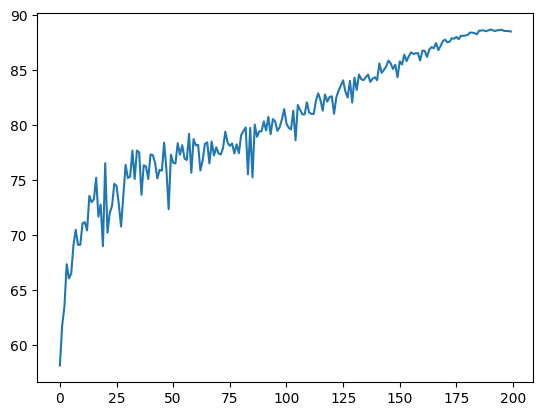

In [15]:
plt.plot(history)